# Single-cell RNA-seq analysis workflow for 1M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import sys
import os

from timeit import default_timer as timer
import time

import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans

import igraph
import louvain

import utils

In [2]:
# Add path to input file here.
input_file = "/data/1M_brain_cells_10X.sparse.h5ad"
USE_FIRST_N_CELLS = 1000000

## Input data

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Tbr1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 25 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

# PCA
n_components = 50 # Number of principal components to compute
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 14s, sys: 8.5 s, total: 1min 23s
Wall time: 1min 22s


(1306127, 27998)

In [6]:
adata.var_names_make_unique()

In [7]:
adata.shape

(1306127, 27998)

In [8]:
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(1000000, 27998)

## Preprocessing

In [9]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [10]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

Trying to set attribute `.obs` of view, copying.


CPU times: user 2min 52s, sys: 1min 18s, total: 4min 10s
Wall time: 4min 10s


Some genes will now have zero expression in all cells. We filter out such genes.

In [11]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 26.1 s, sys: 13.3 s, total: 39.3 s
Wall time: 39.3 s


In [12]:
adata.shape

(989838, 23781)

### Normalize

In [13]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 7.32 s, sys: 1.82 s, total: 9.14 s
Wall time: 9.12 s


In [14]:
%%time
sc.pp.log1p(adata)

CPU times: user 25.3 s, sys: 20 ms, total: 25.4 s
Wall time: 25.3 s


### Select Most Variable Genes

In [15]:
%%time
# Filter matrix to only variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    try:
        adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].todense()
    except KeyError as kex:
        print('Error: ' + str(kex))
        raise kex
adata = adata.copy()
adata = adata[:, adata.var.highly_variable]

CPU times: user 35.1 s, sys: 4.08 s, total: 39.2 s
Wall time: 39.2 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [16]:
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)

In [17]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 19.3 s, sys: 1.65 s, total: 21 s
Wall time: 21 s


In [18]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 12h 49min 4s, sys: 1d 18h 58min 5s, total: 2d 7h 47min 10s
Wall time: 1h 23min 26s


### Scale

In [19]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 49.6 s, sys: 5.32 s, total: 54.9 s
Wall time: 54.9 s


In [20]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 5446.000205755234


## Cluster & Visualize

In [21]:
cluster_start = time.time()

### Reduce

For a fair comparison with the GPU notebook, we use the PCA function from `utils.py`, which uses only a fraction of the cells for training.

In [22]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)

CPU times: user 11min 32s, sys: 3min 36s, total: 15min 9s
Wall time: 38.2 s


### TSNE + K-means

In [23]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 5h 51min 2s, sys: 5min 17s, total: 5h 56min 20s
Wall time: 1h 11min 43s


In [24]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 1.3 s, sys: 1.74 s, total: 3.03 s
Wall time: 1min 24s


... storing 'kmeans' as categorical


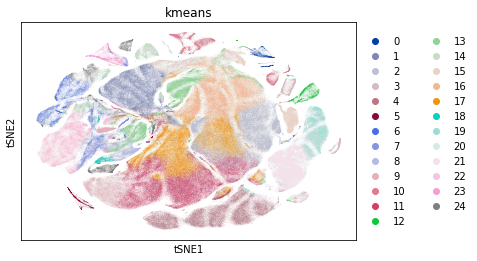

CPU times: user 6.6 s, sys: 3.1 s, total: 9.7 s
Wall time: 5.99 s


In [25]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

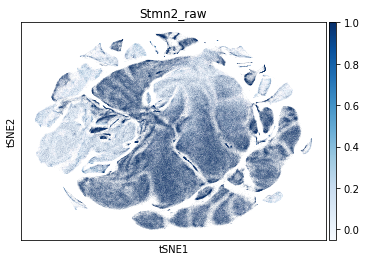

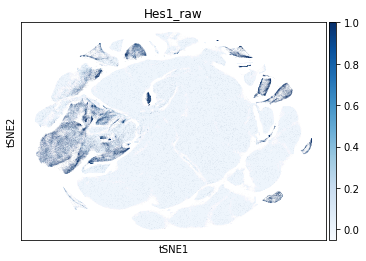

CPU times: user 6.11 s, sys: 368 ms, total: 6.48 s
Wall time: 5.98 s


In [26]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Louvain

In [27]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 8min 48s, sys: 3min 27s, total: 12min 16s
Wall time: 12min 13s


In [28]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 6h 54min 28s, sys: 2h 52min 15s, total: 9h 46min 44s
Wall time: 25min 37s


In [29]:
%%time
# Louvain clustering
sc.tl.louvain(adata, resolution=louvain_resolution)

CPU times: user 10min 41s, sys: 10.3 s, total: 10min 51s
Wall time: 10min 50s


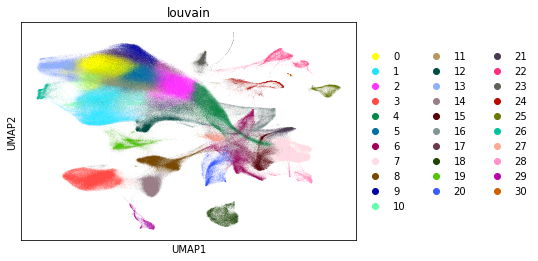

CPU times: user 4.92 s, sys: 192 ms, total: 5.11 s
Wall time: 4.86 s


In [30]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

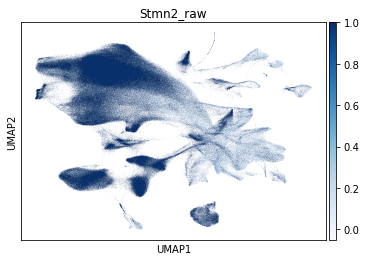

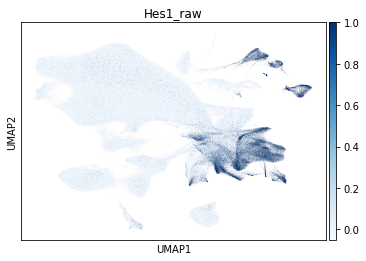

CPU times: user 6.01 s, sys: 416 ms, total: 6.42 s
Wall time: 5.93 s


In [31]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [32]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 7371.296585559845


## Create zoomed-in view

In [33]:
reanalysis_start = time.time()

In [34]:
%%time
adata = adata[adata.obs["Stmn2_raw"] > 0.0, :]
print(adata.X.shape)

(695826, 5000)
CPU times: user 23.5 s, sys: 5.16 s, total: 28.7 s
Wall time: 28.7 s


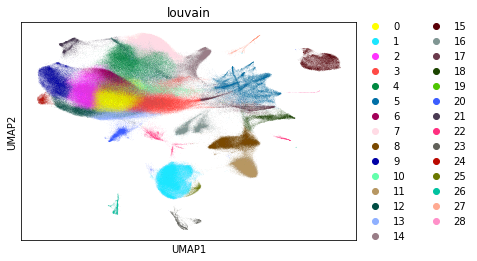

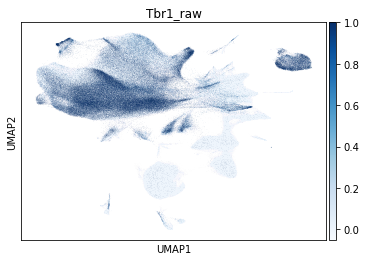

CPU times: user 3h 50min 53s, sys: 2h 13min 22s, total: 6h 4min 15s
Wall time: 41min 10s


In [35]:
%%time

adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.louvain(adata, resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["Tbr1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [36]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 2499.590307712555


In [37]:
print("Full time: %s" % (time.time() - start))

Full time: 15399.436483621597
